# Visualizations 

In [2]:
# imports 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pymongo import MongoClient
from pprint import pprint

from sqlalchemy import create_engine, inspect, text
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
import sqlalchemy

import psycopg2 

In [3]:
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres" 
SQL_IP = "localhost"
PORT = 5432
DATABASE = "crowdfunding_db" 

In [4]:
# create database connection
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)
conn = engine.connect()

### Few quaries to get a feel for the data

In [23]:
# how many enteries are there in our campaign table
query_rows = """
    SELECT COUNT(*)
    FROM campaign
    """
# return from query
with engine.connect() as conn:
    total_rows = pd.read_sql(text(query_rows), conn)
print(total_rows)

   count
0   2000


In [11]:
# what is the top goal out of our campaigns
query_goals = """
    SELECT MAX(goal)
    FROM campaign
    """

# return from query
with engine.connect() as conn:
    top_goal = pd.read_sql(text(query_goals), conn)
print(top_goal)

        max
0  199200.0


In [22]:
# find count of successful outcomes
query_success = """
    SELECT COUNT(*)
    FROM campaign
    WHERE outcome = 'successful'
    """
# return from query
with engine.connect() as conn:
    count_of_success = pd.read_sql(text(query_success), conn)
print(count_of_success)

   count
0   1130


### What is the percentage of successful vs failed campaigns? 

In [4]:
# query for group by of the results of the 'outcome' column 
query_outcome = """
    SELECT outcome, COUNT(*) AS count
    FROM campaign
    GROUP BY outcome;
    """

# create basic dataframe
with engine.connect() as conn:
    outcome_df = pd.read_sql(text(query_outcome), conn) 

# print the data
outcome_df.head()

,outcome,count
0,failed,364
1,live,14
2,canceled,57
3,successful,565


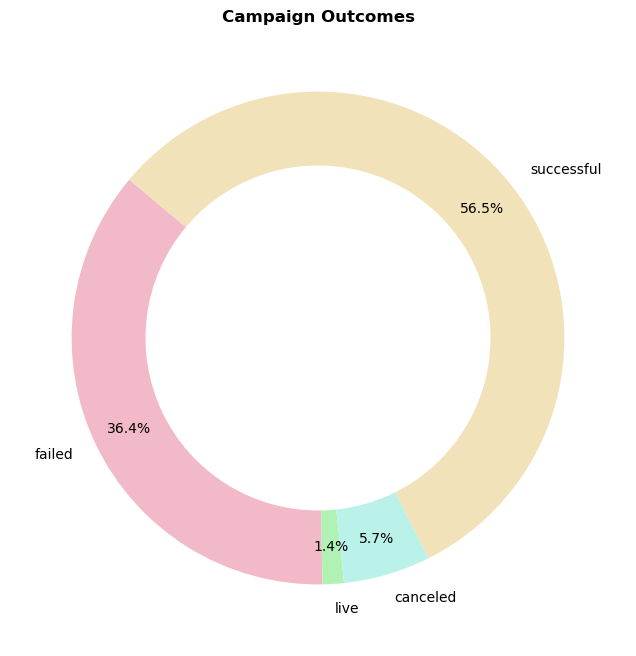

In [5]:
# from the outcome_df make a donut chart to show the outcomes of each campaign in the database
# define the sizes
sizes = outcome_df['count']
labels = outcome_df['outcome']

# set colors 
colors = ['#F2BAC9', '#B0F2B4', '#BAF2E9', '#F2E2BA']  

# create pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.3), pctdistance=0.85)
plt.title('Campaign Outcomes', fontweight='bold')

# show 
plt.show()

### What is the breakdown of category for successful campaigns?

In [6]:
# 1: create query for returning only category_id and outcome for each row 
category_query = """
    SELECT category_id, outcome
    FROM campaign
    WHERE outcome = 'successful';
"""

# return from the database
with engine.connect() as conn:
    category_df = pd.read_sql(text(category_query), conn)

category_df.head()

,category_id,outcome
0,cat1,successful
1,cat1,successful
2,cat1,successful
3,cat1,successful
4,cat1,successful


In [7]:
# 2: get names of categories from 'category' table
category_names = """
    SELECT category_id, category AS category_name
    FROM category;
    """

# return from the database
with engine.connect() as conn:
    category_names_df = pd.read_sql(text(category_names), conn)

category_names_df.head(10)

,category_id,category_name
0,cat1,food
1,cat2,music
2,cat3,technology
3,cat4,theater
4,cat5,film & video
5,cat6,publishing
6,cat7,games
7,cat8,photography
8,cat9,journalism


In [8]:
# 3: merge the dataframes to add the category names 
merged_df = pd.merge(category_df, category_names_df, on='category_id', how='inner')

# groupby each category
category_counts_df = merged_df.groupby('category_name').size().reset_index(name='count')

# sort decending for plot
category_counts_df = category_counts_df.sort_values(by='count', ascending=False)

# Print the aggregated data
category_counts_df.head()

,category_name,count
8,theater,187
0,film & video,102
4,music,99
7,technology,64
6,publishing,40


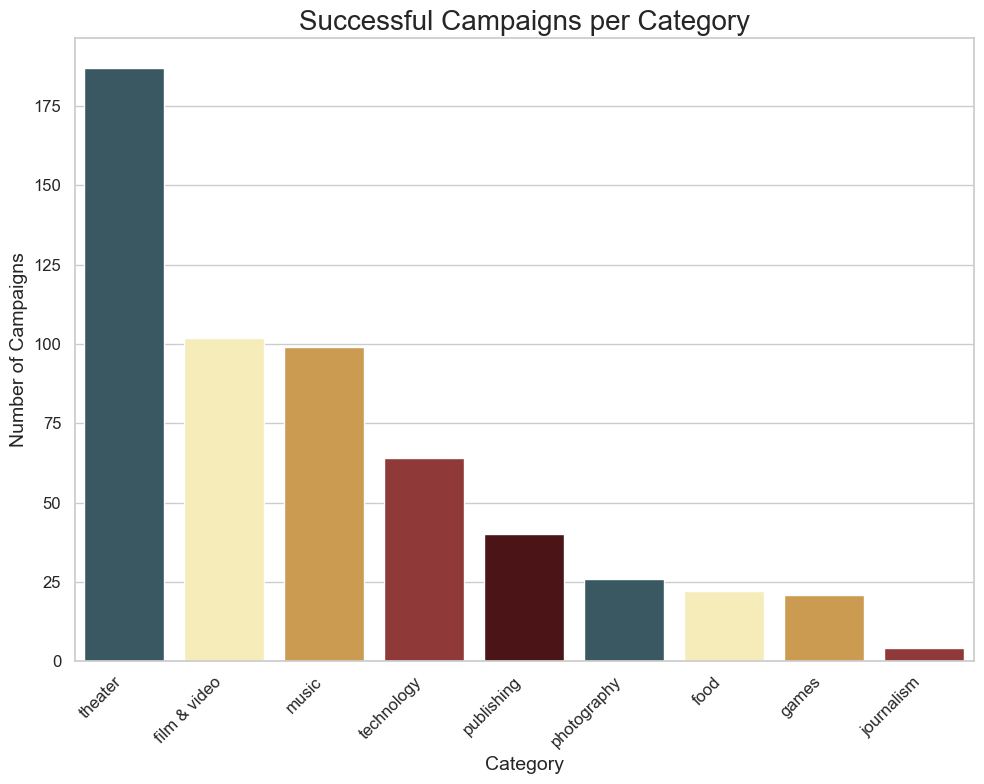

In [9]:
# 4: create bar chart to show successful campaigns per each category
plt.figure(figsize=(10, 8)) 
sns.set_theme(style='whitegrid') 

# colors
custom_pallette = ['#335C67', '#FFF3B0', '#E09F3E', '#9E2A2B', '#540B0E']

# plot
ax = sns.barplot(x='category_name', y='count', data=category_counts_df, palette=custom_pallette)

# customize
plt.title('Successful Campaigns per Category', fontsize=20)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Campaigns', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# show
plt.tight_layout()
plt.show()